<div align="center">
<h1>Toward DNN Deployment Cost Measurements</h1>
Lanxiang Hu
</div>

---


# Reference
[1] Ma, Ningning, et al. **Shufflenet v2: Practical guidelines for efficient cnn architecture design**. Proceedings of the European conference on computer vision (ECCV). 2018. [[paper]](https://arxiv.org/abs/1807.11164v1).

[2] **THOP: PyTorch-OpCounter**. [[code]](https://github.com/Lyken17/pytorch-OpCounter).

[3] **Flops counter for convolutional networks in pytorch framework**. [[code]](https://github.com/sovrasov/flops-counter.pytorch).

[4] Chang, Jiho, et al. **Reducing MAC operation in convolutional neural network with sign prediction.** 2018 International Conference on Information and Communication Technology Convergence (ICTC). IEEE, 2018. [[paper]](https://junheecho.com/assets/papers/ictc18.pdf).

[5] Model optimization: **model FLOPs**. [[slides]](https://indico.cern.ch/event/917049/contributions/3856417/attachments/2034165/3405345/Quantized_CNN_LLP.pdf).

[6] Wang, Xin, et al. **Skipnet: Learning dynamic routing in convolutional networks.** Proceedings of the European Conference on Computer Vision (ECCV). 2018. [[paper]](https://arxiv.org/abs/1711.09485)[[code]](https://github.com/ucbdrive/skipnet).

[7] ICLR‘20 Once-for-All tutorial: **Train One Network and Specialize it for Efficient Deployment**. [[paper]](https://arxiv.org/pdf/1908.09791.pdf), [[code]](https://github.com/mit-han-lab/once-for-all/tree/master/tutorial), [[talk]](https://youtu.be/a_OeT8MXzWI).

# Load Libraries

In [1]:
from tqdm import tqdm

import os
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms, datasets
import numpy as np
import time
import random
import math
import copy
from matplotlib import pyplot as plt

from torchsummary import summary

In [2]:
# set random seed
random_seed = 1
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)
print('Successfully imported all packages and configured random seed to %d!'%random_seed)

Successfully imported all packages and configured random seed to 1!


In [3]:
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
cuda_available = torch.cuda.is_available()
if cuda_available:
    torch.backends.cudnn.enabled = True
    torch.backends.cudnn.benchmark = True
    torch.cuda.manual_seed(random_seed)
    print('Using GPU.')
else:
    print('Using CPU.')

Using GPU.


# Build Evaluator Class

Evaluator class that can be leveraged to measure the deployement cost of a DNN. The costs are usually quantified with the following metrics:
1. Memory cost (in MB).
2. FLOPs.
3. MAC/MACCs (memory access cost/multiply-and-accumulate cost).

For memory cost, notice that the unit used here is MB with $1024^2$B = 1MB. 

According to [2, 3], FLOPs can be quantified by multiplying the size of the feature map on the basis of the parameters. 

$$\text{FLOPs} = \left[\left(K_h \times K_w\right) \times c_1 +1\right]  \left( h \times w \right) c_2 \\
= h w\left[  K_h \times K_w\times c_1c_2 + c_2\right] \\
= \text{feature map size} \times  \text{number of parameters}$$

Notice that The input and output to convolutional layers are three-dimensional feature maps or namely tensors of size $h \times w \times c$ where $h$ and $w$ are spatial sizes of the feature map.

For memory access cost (MAC), It can be quantified with number of multiply-and-accumulate operations (MACCs). [1] proposes a metric that sets a lower bound for MAC as 


$$\text{MAC} \geq 2 \sqrt{h w B} + \dfrac{B}{hw}$$

It reaches the lower bound when input channels and output channels are equal.

For $1\times 1$ group convolution, MAC can be precisely calculated as

$$\text{MAC} = hw (c_1+c_2) + \dfrac{c_1 c_2}{g} \\
= hwc_1 + \dfrac{Bg}{c_1} + \dfrac{B}{hw}$$

According to [2, 3], for a convolutional layer with kernel size $K$, MAC can be quantified with the number of MACCs as

$$\text{MAC} = \left(K\times K\right) \times \left(h \times w \right)\times c_1 \times c_2 \\
= \text{kernel size} \times \text{feature map size} \times \text{input channel} \times \text{output channel}$$





In [4]:
class CostEvaluator:
  def __init__(self, **kwargs):
    # hyper-parameters
    self.turn_on_log = kwargs.get("turn_on_log", 0)

  def memory_size_evaluator(self, nn_model):
    param_size = 0
    for param in nn_model.parameters():
        param_size += param.nelement() * param.element_size()
    buffer_size = 0
    for buffer in nn_model.buffers():
        buffer_size += buffer.nelement() * buffer.element_size()

    total_size_mb = (param_size + buffer_size) / 1024**2
    print('model size: {:.3f}MB'.format(total_size_mb))
    return total_size_mb

  def flops_evaluator(self, nn_model, in_channels, input_h, input_w):
    # summing all layers together
    total_flops = 0
    h_prev = 0
    w_prev = 0
    h = input_h
    w = input_w
    c_prev = in_channels

    counter = 0
    # unwrap nn model
    unwrapped_model = [module for module in nn_model.modules() if not isinstance(module, torch.nn.modules.container.Sequential) and not isinstance(module, torchvision.models.resnet.ResNet)]

    for module in unwrapped_model:
      if (self.turn_on_log):
        print('processing layer {}'.format(counter))
        print('layer type: {}'.format(type(module)))
      # there is a possible change in output size if the module is a convolutional layer or maxpool layer
      if (type(module) == torch.nn.modules.conv.Conv2d or type(module) == torch.nn.modules.pooling.MaxPool2d):
        if (type(module.kernel_size) == int):
          # handle int cases
          if (module.kernel_size > 1 and module.stride > 1):
            ratio = module.stride
            h_prev = h
            w_prev = w
            h = h / ratio
            w = w / ratio
            if (self.turn_on_log): print('output dimensions shrinking')
        else:
          # handle tuple cases
          if ((module.kernel_size[0] > 1 or module.kernel_size[1] > 1) and (module.stride[0] > 1 or module.stride[1] > 1)):
            ratio = module.stride[0]
            h_prev = h
            w_prev = w
            h = h / ratio
            w = w / ratio
            if (self.turn_on_log): print('output dimensions shrinking')
      elif (type(module) == torch.nn.modules.pooling.AdaptiveAvgPool2d):
        h_prev = h
        w_prev = w
        h = 1
        w = 1

      if (type(module) == torch.nn.Conv2d):
        # convolutional layer.
        if (self.turn_on_log): print('calculating FLOPs for Conv2d...')
        c_prev = module.out_channels
        total_flops += ((module.kernel_size[0] * module.kernel_size[1]) * module.in_channels  + 1) * (h * w) * module.out_channels
      elif (type(module) == torch.nn.MaxPool2d):
        # handle else case with maxpool
        if (self.turn_on_log): print('calculating FLOPs for MaxPool2d...')
        # number of filters
        n_1 = h_prev / module.stride
        n_2 = w_prev / module.stride
        n_tot = n_1 * n_2
        # note that number of channels should be held unchanged
        total_flops += (module.kernel_size * module.kernel_size + 1) * (h * w) * c_prev * n_tot
      elif (type(module) == torch.nn.ReLU):
        # handle else case with ReLU 
        # Assuming number of flops equal to length of input vector, ReLU takes 1 comparison and 1 multiplication
        if (self.turn_on_log): print('calculating FLOPs for ReLU...')
        total_flops += 2 * (h * w) * c_prev
      elif (type(module) == torch.nn.BatchNorm2d):
        # handle else case with BatchNorm
        if (self.turn_on_log): print('calculating FLOPs for BatchNorm2d...')
        mean_ops = (h * w) * module.num_features + 1
        std_ops = 2 * ((h * w) * module.num_features + 1)
        normalization_ops = 2 * (h * w) * module.num_features
        scale_and_shift_ops = 2 * (h * w) * module.num_features
        total_flops += mean_ops + std_ops + normalization_ops + scale_and_shift_ops

      counter += 1
      if (self.turn_on_log): print('------------------')

    total_flops_G = total_flops / 10**9
    print('total FLOPs: {:.3f} = {}G'.format(total_flops, total_flops_G))
    return total_flops


  def mac_evaluator(self, nn_model, input_h, input_w):
    # summing all layers together
    total_mac = 0
    h = input_h
    w = input_w

    # unwrap the nn model
    # the complete ResNet object is specifically excluded
    unwrapped_model = [module for module in nn_model.modules() if not isinstance(module, torch.nn.modules.container.Sequential) and not isinstance(module, torchvision.models.resnet.ResNet)]

    counter = 0
    for module in unwrapped_model:
      if (self.turn_on_log): print('processing layer {}'.format(counter))
      if (self.turn_on_log): print('layer type: {}'.format(type(module)))
      if (type(module) == torch.nn.modules.conv.Conv2d or type(module) == torch.nn.modules.pooling.MaxPool2d):
        if (type(module.kernel_size) == int):
          # handle int case
          if (module.kernel_size > 1 and module.stride > 1):
            ratio = module.stride
            h = h / ratio
            w = w / ratio
            if (self.turn_on_log): print('output dimensions shrinking')
        else:
          # handle tuple case
          if ((module.kernel_size[0] > 1 or module.kernel_size[1] > 1) and (module.stride[0] > 1 or module.stride[1] > 1)):
            ratio = module.stride[0]
            h = h / ratio
            w = w / ratio
            if (self.turn_on_log): print('output dimensions shrinking')
      elif (type(module) == torch.nn.modules.pooling.AdaptiveAvgPool2d):
        h_prev = h
        w_prev = w
        h = 1
        w = 1

      if (type(module) == torch.nn.Conv2d):
        # MAC operations are dominated by computations carried out in convolutional layer
        total_mac += (module.in_channels * module.out_channels) * (h * w) * (module.kernel_size[0] * module.kernel_size[1])
      counter += 1
      if (self.turn_on_log): print('------------------')
    total_mac_G = total_mac / 10**9
    print('total MACCs: {:.3f} = {}G'.format(total_mac, total_mac_G))
    return total_mac
  
  def inference_time_evaluator(self, device_flops, device_name, nn_model, in_channels, input_h, input_w):
    print('starting inference time analysis...')
    total_flop = self.flops_evaluator(nn_model, in_channels, input_h, input_w)
    inf_time = total_flop / device_flops
    print('total inference time: {:.3f}s with {}'.format(inf_time, device_name))
    return total_flop / device_flops

  def power_evaluator(self, device_power_spec, device_flops, nn_model, in_channels, input_h, input_w):
    print('starting inference power analysis...')
    total_flop = self.flops_evaluator(nn_model, in_channels, input_h, input_w)
    inf_time = total_flop / device_flops
    power = inf_time * device_power_spec
    print('total inference power consumption: {:.3f}s'.format(power))
    return power

# ResNet50 Deployment Cost Estimation

In [75]:
resnet_50 = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.10.0.zip" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [19]:
# Consider standard imagenet input
summary(resnet_50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [88]:
unwrapped_resnet50 = [module for module in resnet_50.modules() if not isinstance(module, torch.nn.modules.container.Sequential) and not isinstance(module, torchvision.models.resnet.ResNet)]
param_size = 0
counter = 0

for module in unwrapped_resnet50:
  print(type(module))
  counter += 1
print(counter)

counter = 0
for param in resnet_50.parameters():
  counter += 1
print(counter)

<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.pooling.MaxPool2d'>
<class 'torchvision.models.resnet.Bottleneck'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torchvision.models.resnet.Bottleneck'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.conv.Conv2d'>
<class 'torch.nn.modules.batchnorm.BatchNorm2d'>
<class 'torch.nn.modules.activation.ReLU'>
<class 'torchvision.models.r

In [76]:
unwrapped_resnet50 = [module for module in resnet_50.modules() if not isinstance(module, torch.nn.modules.container.Sequential) and not isinstance(module, torchvision.models.resnet.ResNet)]
for module in unwrapped_resnet50:
  if (type(module) == torch.nn.modules.conv.Conv2d or type(module) == torch.nn.modules.pooling.MaxPool2d):
    print(module.kernel_size)
    if (type(module.kernel_size) == int):
      # handle int case
      if (module.kernel_size > 1 and module.stride > 1):
        print(module)
        print(module.stride)
        print('size shrinking')
    else:
      # handle tuple case
      if ((module.kernel_size[0] > 1 or module.kernel_size[1] > 1) and (module.stride[0] > 1 or module.stride[1] > 1)):
        print(module)
        print(module.stride)
        print('size shrinking')
    print("---------------------")

(7, 7)
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
(2, 2)
size shrinking
---------------------
3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
2
size shrinking
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
(2, 2)
size shrinking
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------

In [77]:
evaluator = CostEvaluator();

In [78]:
resnet50_mem = evaluator.memory_size_evaluator(resnet_50)
# consider running resnet50 on Cortex A76 with 3GHz and 16FLOPs for single-point precision
a76_flops = 16 * 3 * 10**9
jetson_nx_flops = 1.33 * 10**(12) # 1.33 TFLOPs
rtx_2080_flops = 13.45 * 10**(12) # 13.45 TFLOPs
gtx_1080_flops = 9 * 10**(12) # 9 TFLOPs
resnet50_flops = evaluator.flops_evaluator(resnet_50, 3, 224, 224)
resnet50_mac = evaluator.mac_evaluator(resnet_50, 224, 224)
resnet50_inference_a76 = evaluator.inference_time_evaluator(a76_flops, 'Cortex A76', resnet_50, 3, 224, 224)
resnet50_inference_nx = evaluator.inference_time_evaluator(jetson_nx_flops, 'Jetson Xavier NX', resnet_50, 3, 224, 224)
resnet50_inference_rtx2080 = evaluator.inference_time_evaluator(rtx_2080_flops, 'RTX 2080 GPU', resnet_50, 3, 224, 224)
resnet50_inference_gtx1080 = evaluator.inference_time_evaluator(gtx_1080_flops, 'GTX 1080 GPU', resnet_50, 3, 224, 224)

model size: 97.695MB
total FLOPs: 10482770079.000 = 10.482770079G
total MACCs: 4087136256.000 = 4.087136256G
starting inference time analysis...
total FLOPs: 10482770079.000 = 10.482770079G
total inference time: 0.218s with Cortex A76
starting inference time analysis...
total FLOPs: 10482770079.000 = 10.482770079G
total inference time: 0.008s with Jetson Xavier NX
starting inference time analysis...
total FLOPs: 10482770079.000 = 10.482770079G
total inference time: 0.001s with RTX 2080 GPU
starting inference time analysis...
total FLOPs: 10482770079.000 = 10.482770079G
total inference time: 0.001s with GTX 1080 GPU


# Dynamically Gated ResNet_50 (SkipNet) Cost Estimation

In [5]:
!git clone https://github.com/ucbdrive/skipnet.git

Cloning into 'skipnet'...
remote: Enumerating objects: 261, done.
remote: Total 261 (delta 0), reused 0 (delta 0), pack-reused 261
Receiving objects: 100% (261/261), 1.69 MiB | 9.86 MiB/s, done.
Resolving deltas: 100% (123/123), done.


In [15]:
!curl 'http://people.eecs.berkeley.edu/~xinw/skipnet/resnet-50-rnn-sp-imagenet.pth.tar'

In [28]:
!curl "http://people.eecs.berkeley.edu/~xinw/skipnet/resnet-50-rnn-sp-imagenet.pth.tar" \
  -o resnet-50-rnn-sp-imagenet.pth.tar

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 98.3M  100 98.3M    0     0  71.5M      0  0:00:01  0:00:01 --:--:-- 71.5M


In [21]:
from skipnet.imagenet import models

In [23]:
from pkgutil import iter_modules

def list_submodules(module):
    for submodule in iter_modules(module.__path__):
        print(submodule.name)

list_submodules(skipnet.imagenet)

models
train_base
train_rl
train_sp


In [24]:
rnn_gate_50 = models.imagenet_rnn_gate_50(pretrained=True)

In [87]:
unwrapped_rnn_gate_50 = [module for module in rnn_gate_50.modules() if not isinstance(module, torch.nn.modules.container.Sequential) and not isinstance(module, torchvision.models.resnet.ResNet)]
for module in unwrapped_rnn_gate_50:
  if (type(module) == torch.nn.modules.conv.Conv2d or type(module) == torch.nn.modules.pooling.MaxPool2d):
    print(module.kernel_size)
    if (type(module.kernel_size) == int):
      # handle int case
      if (module.kernel_size > 1 and module.stride > 1):
        print(module)
        print(module.stride)
        print('size shrinking')
    else:
      # handle tuple case
      if ((module.kernel_size[0] > 1 or module.kernel_size[1] > 1) and (module.stride[0] > 1 or module.stride[1] > 1)):
        print(module)
        print(module.stride)
        print('size shrinking')
    print("---------------------")

(7, 7)
Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
(2, 2)
size shrinking
---------------------
3
MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
2
size shrinking
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
Conv2d(128, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
(2, 2)
size shrinking
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------

In [72]:
evaluator = CostEvaluator();

In [73]:
rnn_gate_50_mem = evaluator.memory_size_evaluator(rnn_gate_50)
# consider running resnet50 on Cortex A76 with 3GHz and 16FLOPs for single-point precision
a76_flops = 16 * 3 * 10**9
jetson_nx_flops = 1.33 * 10**(12) # 1.33 TFLOPs
rtx_2080_flops = 13.45 * 10**(12) # 13.45 TFLOPs
gtx_1080_flops = 9 * 10**(12) # 9 TFLOPs
rnn_gate_50_flops = evaluator.flops_evaluator(rnn_gate_50, 3, 224, 224)
rnn_gate_50_mac = evaluator.mac_evaluator(rnn_gate_50, 224, 224)
rnn_gate_50_inference_a76 = evaluator.inference_time_evaluator(a76_flops, 'Cortex A76', rnn_gate_50, 3, 224, 224)
rnn_gate_50_inference_nx = evaluator.inference_time_evaluator(jetson_nx_flops, 'Jetson Xavier NX', rnn_gate_50, 3, 224, 224)
rnn_gate_50_inference_rtx2080 = evaluator.inference_time_evaluator(rtx_2080_flops, 'RTX 2080 GPU', rnn_gate_50, 3, 224, 224)
rnn_gate_50_inference_gtx1080 = evaluator.inference_time_evaluator(gtx_1080_flops, 'GTX 1080 GPU', rnn_gate_50, 3, 224, 224)

model size: 98.276MB
total FLOPs: 11479806056.000 = 11.479806056G
total MACCs: 5067174378.000 = 5.067174378G
starting inference time analysis...
total FLOPs: 11479806056.000 = 11.479806056G
total inference time: 0.239s with Cortex A76
starting inference time analysis...
total FLOPs: 11479806056.000 = 11.479806056G
total inference time: 0.009s with Jetson Xavier NX
starting inference time analysis...
total FLOPs: 11479806056.000 = 11.479806056G
total inference time: 0.001s with RTX 2080 GPU
starting inference time analysis...
total FLOPs: 11479806056.000 = 11.479806056G
total inference time: 0.001s with GTX 1080 GPU


# OFA Cost Estimation (MobileNetV3 as the backbone NN)

## Full Model

In [6]:
print('Installing thop (FLOPs counter) ...')
! pip install thop 1>/dev/null
# ofa is a package containing training code, pretrained specialized models and inference code for the once-for-all networks.
print('Installing OFA...')
! pip install ofa 1>/dev/null
# tqdm is a package for displaying a progress bar.
print('Installing tqdm (progress bar) ...')
! pip install tqdm 1>/dev/null
print('Installing matplotlib...')
! pip install matplotlib 1>/dev/null

Installing thop (FLOPs counter) ...
Installing OFA...
Installing tqdm (progress bar) ...
Installing matplotlib...


In [7]:
from ofa.model_zoo import ofa_net
from ofa.utils import download_url

In [8]:
from ofa.tutorial import AccuracyPredictor, FLOPsTable, LatencyTable, EvolutionFinder
from ofa.tutorial import evaluate_ofa_subnet, evaluate_ofa_specialized

In [9]:
ofa_network = ofa_net('ofa_mbv3_d234_e346_k357_w1.2', pretrained=True)
print('The OFA Network is ready.')

Downloading: "https://hanlab.mit.edu/files/OnceForAll/ofa_nets/ofa_mbv3_d234_e346_k357_w1.2" to .torch/ofa_nets/ofa_mbv3_d234_e346_k357_w1.2


The OFA Network is ready.


In [10]:
unwrapped_ofa_network = [module for module in ofa_network.modules() if not isinstance(module, torch.nn.modules.container.Sequential) and not isinstance(module, torchvision.models.resnet.ResNet)]
for module in unwrapped_ofa_network:
  if (type(module) == torch.nn.modules.conv.Conv2d or type(module) == torch.nn.modules.pooling.MaxPool2d):
    print(module.kernel_size)
    if (type(module.kernel_size) == int):
      # handle int case
      if (module.kernel_size > 1 and module.stride > 1):
        print(module)
        print(module.stride)
        print('size shrinking')
    else:
      # handle tuple case
      if ((module.kernel_size[0] > 1 or module.kernel_size[1] > 1) and (module.stride[0] > 1 or module.stride[1] > 1)):
        print(module)
        print(module.stride)
        print('size shrinking')
    print("---------------------")

(3, 3)
Conv2d(3, 24, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
(2, 2)
size shrinking
---------------------
(3, 3)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(7, 7)
Conv2d(144, 144, kernel_size=(7, 7), stride=(2, 2), groups=144, bias=False)
(2, 2)
size shrinking
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(7, 7)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(7, 7)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(7, 7)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(7, 7)
Conv2d(192, 192, kernel_size=(7, 7), stride=(2, 2), groups=192, bias=False)
(2, 2)
size shrinking
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(7, 7)
---------------------
(1, 1)
---------------------
(1, 1)
---------------------
(1, 1)
--

In [11]:
evaluator = CostEvaluator();

In [12]:
ofa_network_mem = evaluator.memory_size_evaluator(ofa_network)
# consider running resnet50 on Cortex A76 with 3GHz and 16FLOPs for single-point precision
a76_flops = 16 * 3 * 10**9
jetson_nx_flops = 1.33 * 10**(12) # 1.33 TFLOPs
rtx_2080_flops = 13.45 * 10**(12) # 13.45 TFLOPs
gtx_1080_flops = 9 * 10**(12) # 9 TFLOPs
ofa_network_flops = evaluator.flops_evaluator(ofa_network, 3, 224, 224)
ofa_network_mac = evaluator.mac_evaluator(ofa_network, 224, 224)
ofa_network_inference_a76 = evaluator.inference_time_evaluator(a76_flops, 'Cortex A76', ofa_network, 3, 224, 224)
ofa_network_inference_nx = evaluator.inference_time_evaluator(jetson_nx_flops, 'Jetson Xavier NX', ofa_network, 3, 224, 224)
ofa_network_inference_rtx2080 = evaluator.inference_time_evaluator(rtx_2080_flops, 'RTX 2080 GPU', ofa_network, 3, 224, 224)
ofa_network_inference_gtx1080 = evaluator.inference_time_evaluator(gtx_1080_flops, 'GTX 1080 GPU', ofa_network, 3, 224, 224)

model size: 41.072MB
total FLOPs: 76392489792.000 = 76.392489792G
total MACCs: 76273854720.000 = 76.27385472G
starting inference time analysis...
total FLOPs: 76392489792.000 = 76.392489792G
total inference time: 1.592s with Cortex A76
starting inference time analysis...
total FLOPs: 76392489792.000 = 76.392489792G
total inference time: 0.057s with Jetson Xavier NX
starting inference time analysis...
total FLOPs: 76392489792.000 = 76.392489792G
total inference time: 0.006s with RTX 2080 GPU
starting inference time analysis...
total FLOPs: 76392489792.000 = 76.392489792G
total inference time: 0.008s with GTX 1080 GPU


## Subnet for SamSung Note10

ImageNet Dataset:

In [13]:
if cuda_available:
    # path to the ImageNet dataset
    print("Please input the path to the ImageNet dataset.\n")
    imagenet_data_path = input()

    # if 'imagenet_data_path' is empty, download a subset of ImageNet containing 2000 images (~250M) for test
    if not os.path.isdir(imagenet_data_path):
        os.makedirs(imagenet_data_path, exist_ok=True)
        download_url('https://hanlab.mit.edu/files/OnceForAll/ofa_cvpr_tutorial/imagenet_1k.zip', model_dir='data')
        ! cd data && unzip imagenet_1k 1>/dev/null && cd ..
        ! cp -r data/imagenet_1k/* $imagenet_data_path
        ! rm -rf data
        print('%s is empty. Download a subset of ImageNet for test.' % imagenet_data_path)

    print('The ImageNet dataset files are ready.')
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

Please input the path to the ImageNet dataset.

/home/dataset


Downloading: "https://hanlab.mit.edu/files/OnceForAll/ofa_cvpr_tutorial/imagenet_1k.zip" to data/imagenet_1k.zip


/home/dataset is empty. Download a subset of ImageNet for test.
The ImageNet dataset files are ready.


Dataloader:

In [14]:
if cuda_available:
    # The following function build the data transforms for test
    def build_val_transform(size):
        return transforms.Compose([
            transforms.Resize(int(math.ceil(size / 0.875))),
            transforms.CenterCrop(size),
            transforms.ToTensor(),
            transforms.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]
            ),
        ])

    data_loader = torch.utils.data.DataLoader(
        datasets.ImageFolder(
            root=os.path.join(imagenet_data_path, 'val'),
            transform=build_val_transform(224)
        ),
        batch_size=250,  # test batch size
        shuffle=True,
        num_workers=16,  # number of workers for the data loader
        pin_memory=True,
        drop_last=False,
    )
    print('The ImageNet dataloader is ready.')
else:
    data_loader = None
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

The ImageNet dataloader is ready.


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [15]:
# accuracy predictor
accuracy_predictor = AccuracyPredictor(
    pretrained=True,
    device='cuda:0' if cuda_available else 'cpu'
)

print('The accuracy predictor is ready!')
print(accuracy_predictor.model)

Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/acc_predictor.pth" to /root/.torch/acc_predictor.pth


The accuracy predictor is ready!
Sequential(
  (0): Linear(in_features=128, out_features=400, bias=True)
  (1): ReLU()
  (2): Linear(in_features=400, out_features=400, bias=True)
  (3): ReLU()
  (4): Linear(in_features=400, out_features=400, bias=True)
  (5): ReLU()
  (6): Linear(in_features=400, out_features=1, bias=True)
)


In [16]:
target_hardware = 'note10'
latency_table = LatencyTable(device=target_hardware)
print('The Latency lookup table on %s is ready!' % target_hardware)

Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/160_lookup_table.yaml" to /root/.hancai/latency_tools/160_lookup_table.yaml


Built latency table for image size: 160.


Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/176_lookup_table.yaml" to /root/.hancai/latency_tools/176_lookup_table.yaml


Built latency table for image size: 176.


Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/192_lookup_table.yaml" to /root/.hancai/latency_tools/192_lookup_table.yaml


Built latency table for image size: 192.


Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/208_lookup_table.yaml" to /root/.hancai/latency_tools/208_lookup_table.yaml


Built latency table for image size: 208.


Downloading: "https://hanlab.mit.edu/files/OnceForAll/tutorial/latency_table@note10/224_lookup_table.yaml" to /root/.hancai/latency_tools/224_lookup_table.yaml


Built latency table for image size: 224.
The Latency lookup table on note10 is ready!


In [17]:
""" Hyper-parameters for the evolutionary search process
    You can modify these hyper-parameters to see how they influence the final ImageNet accuracy of the search sub-net.
"""
latency_constraint = 25  # ms, suggested range [15, 33] ms
P = 100  # The size of population in each generation
N = 500  # How many generations of population to be searched
r = 0.25  # The ratio of networks that are used as parents for next generation
params = {
    'constraint_type': target_hardware, # Let's do latency-constrained search
    'efficiency_constraint': latency_constraint,
    'mutate_prob': 0.1, # The probability of mutation in evolutionary search
    'mutation_ratio': 0.5, # The ratio of networks that are generated through mutation in generation n >= 2.
    'efficiency_predictor': latency_table, # To use a predefined efficiency predictor.
    'accuracy_predictor': accuracy_predictor, # To use a predefined accuracy_predictor predictor.
    'population_size': P,
    'max_time_budget': N,
    'parent_ratio': r,
}

# build the evolution finder
finder = EvolutionFinder(**params)

# start searching
result_lis = []
st = time.time()
best_valids, best_info = finder.run_evolution_search()
result_lis.append(best_info)
ed = time.time()
print('Found best architecture on %s with latency <= %.2f ms in %.2f seconds! '
      'It achieves %.2f%s predicted accuracy with %.2f ms latency on %s.' %
      (target_hardware, latency_constraint, ed-st, best_info[0] * 100, '%', best_info[-1], target_hardware))

# visualize the architecture of the searched sub-net
_, net_config, latency = best_info
ofa_network.set_active_subnet(ks=net_config['ks'], d=net_config['d'], e=net_config['e'])
print('Architecture of the searched sub-net:')
print(ofa_network.module_str)

Searching with note10 constraint (25): 100%|██████████| 500/500 [00:19<00:00, 25.59it/s]

Found best architecture on note10 with latency <= 25.00 ms in 19.70 seconds! It achieves 81.44% predicted accuracy with 24.89 ms latency on note10.
Architecture of the searched sub-net:
3x3_Conv_O24_H_SWISH_BN
(3x3_MBConv1_RELU_O24_BN, Identity)
((O32, E3.0, K5), None)
((O32, E4.0, K3), Identity)
(SE(O48, E4.0, K7), None)
(SE(O48, E4.0, K5), Identity)
((O96, E4.0, K7), None)
((O96, E3.0, K7), Identity)
((O96, E4.0, K3), Identity)
(SE(O136, E6.0, K3), None)
(SE(O136, E3.0, K5), Identity)
(SE(O136, E3.0, K5), Identity)
(SE(O136, E3.0, K3), Identity)
(SE(O192, E6.0, K7), None)
(SE(O192, E6.0, K3), Identity)
(SE(O192, E4.0, K3), Identity)
(SE(O192, E3.0, K5), Identity)
1x1_Conv_O1152_H_SWISH_BN
1x1_Conv_O1536_H_SWISH
1536x1000_Linear



Evaluating the sub-network with latency = 24.9 ms on note10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:490: UserWarning: This DataLoader will create 16 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Validate: 100%|██████████| 4/4 [00:07<00:00,  1.97s/it, loss=0.926, top1=78.2, top5=94.8, img_size=192]

Results: loss=0.92586,	 top1=78.2,	 top5=94.8


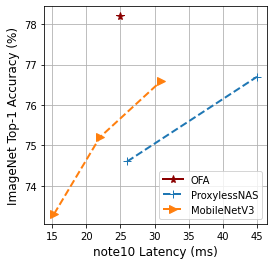

Successfully draw the tradeoff curve!


In [18]:
# evaluate the searched model on ImageNet
if cuda_available:
    top1s = []
    latency_list = []
    for result in result_lis:
        _, net_config, latency = result
        print('Evaluating the sub-network with latency = %.1f ms on %s' % (latency, target_hardware))
        top1 = evaluate_ofa_subnet(
            ofa_network,
            imagenet_data_path,
            net_config,
            data_loader,
            batch_size=250,
            device='cuda:0' if cuda_available else 'cpu')
        top1s.append(top1)
        latency_list.append(latency)

    plt.figure(figsize=(4,4))
    plt.plot(latency_list, top1s, 'x-', marker='*', color='darkred',  linewidth=2, markersize=8, label='OFA')
    plt.plot([26, 45], [74.6, 76.7], '--', marker='+', linewidth=2, markersize=8, label='ProxylessNAS')
    plt.plot([15.3, 22, 31], [73.3, 75.2, 76.6], '--', marker='>', linewidth=2, markersize=8, label='MobileNetV3')
    plt.xlabel('%s Latency (ms)' % target_hardware, size=12)
    plt.ylabel('ImageNet Top-1 Accuracy (%)', size=12)
    plt.legend(['OFA', 'ProxylessNAS', 'MobileNetV3'], loc='lower right')
    plt.grid(True)
    plt.show()
    print('Successfully draw the tradeoff curve!')
else:
    print('Since GPU is not found in the environment, we skip all scripts related to ImageNet evaluation.')

In [19]:
evaluator = CostEvaluator();

Consider only the OFA subnet:

In [22]:
ofa_network_mem = evaluator.memory_size_evaluator(ofa_network.get_active_subnet())
# consider running resnet50 on Cortex A76 with 3GHz and 16FLOPs for single-point precision
a76_flops = 16 * 3 * 10**9
jetson_nx_flops = 1.33 * 10**(12) # 1.33 TFLOPs
rtx_2080_flops = 13.45 * 10**(12) # 13.45 TFLOPs
gtx_1080_flops = 9 * 10**(12) # 9 TFLOPs
ofa_network_flops = evaluator.flops_evaluator(ofa_network.get_active_subnet(), 3, 224, 224)
ofa_network_mac = evaluator.mac_evaluator(ofa_network.get_active_subnet(), 224, 224)
ofa_network_inference_a76 = evaluator.inference_time_evaluator(a76_flops, 'Cortex A76', ofa_network.get_active_subnet(), 3, 224, 224)
ofa_network_inference_nx = evaluator.inference_time_evaluator(jetson_nx_flops, 'Jetson Xavier NX', ofa_network.get_active_subnet(), 3, 224, 224)
ofa_network_inference_rtx2080 = evaluator.inference_time_evaluator(rtx_2080_flops, 'RTX 2080 GPU', ofa_network.get_active_subnet(), 3, 224, 224)
ofa_network_inference_gtx1080 = evaluator.inference_time_evaluator(gtx_1080_flops, 'GTX 1080 GPU', ofa_network.get_active_subnet(), 3, 224, 224)

model size: 28.774MB
total FLOPs: 9689571395.000 = 9.689571395G
total MACCs: 9635899392.000 = 9.635899392G
starting inference time analysis...
total FLOPs: 9689571395.000 = 9.689571395G
total inference time: 0.202s with Cortex A76
starting inference time analysis...
total FLOPs: 9689571395.000 = 9.689571395G
total inference time: 0.007s with Jetson Xavier NX
starting inference time analysis...
total FLOPs: 9689571395.000 = 9.689571395G
total inference time: 0.001s with RTX 2080 GPU
starting inference time analysis...
total FLOPs: 9689571395.000 = 9.689571395G
total inference time: 0.001s with GTX 1080 GPU
